In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [2]:
df = pd.read_pickle("data/flickr_data_cleaned.pkl")
df.head(5)

,id,user,lat,long,tags,title,date_upload,date_taken,url
0,4395181099,30624617@N03,45.754858,4.821710,"[chair, lyon, rhône, chaise, rhônealpes]",Chaises avec vue,2010-02-28 20:23:00,2010-02-28 15:11:00,https://www.flickr.com/photos/30624617@N03/439...
1,4394748717,35853470@N00,45.753270,4.862953,[],,2010-02-28 17:52:00,2010-02-28 17:51:00,https://www.flickr.com/photos/35853470@N00/439...
2,4394694699,11817998@N05,45.760655,4.846564,"[365, iphone]",59/365 - R46 V103 B163,2010-02-28 17:33:00,2010-02-28 17:29:00,https://www.flickr.com/photos/11817998@N05/439...
3,4394803790,11545749@N06,45.784000,4.874072,"[nin, nineinchnails, gift, screening, toiou, a...",2010-01-29 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:15:00,https://www.flickr.com/photos/11545749@N06/439...
4,4394803554,11545749@N06,45.784000,4.874072,"[lyon, nin, nineinchnails, gift, screening, to...",2010-01-28 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:10:00,https://www.flickr.com/photos/11545749@N06/439...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185209 entries, 0 to 420239
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           185209 non-null  int64         
 1   user         185209 non-null  object        
 2   lat          185209 non-null  float64       
 3   long         185209 non-null  float64       
 4   tags         185209 non-null  object        
 5   title        185209 non-null  object        
 6   date_upload  185209 non-null  datetime64[ns]
 7   date_taken   185209 non-null  datetime64[ns]
 8   url          185209 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 14.1+ MB


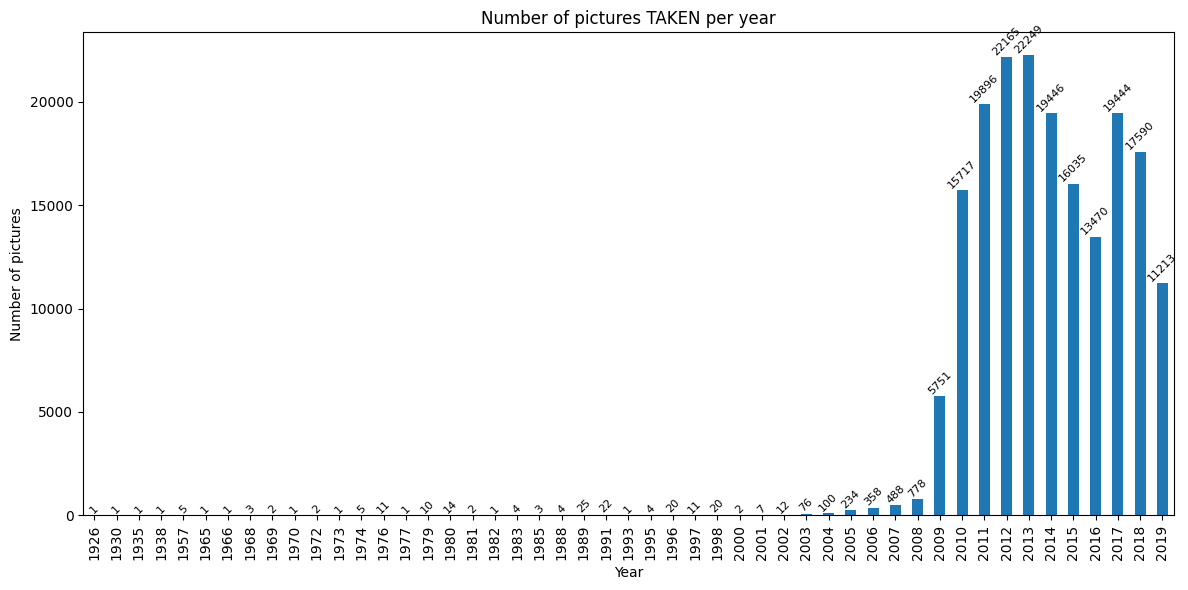

In [4]:
ax = df["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

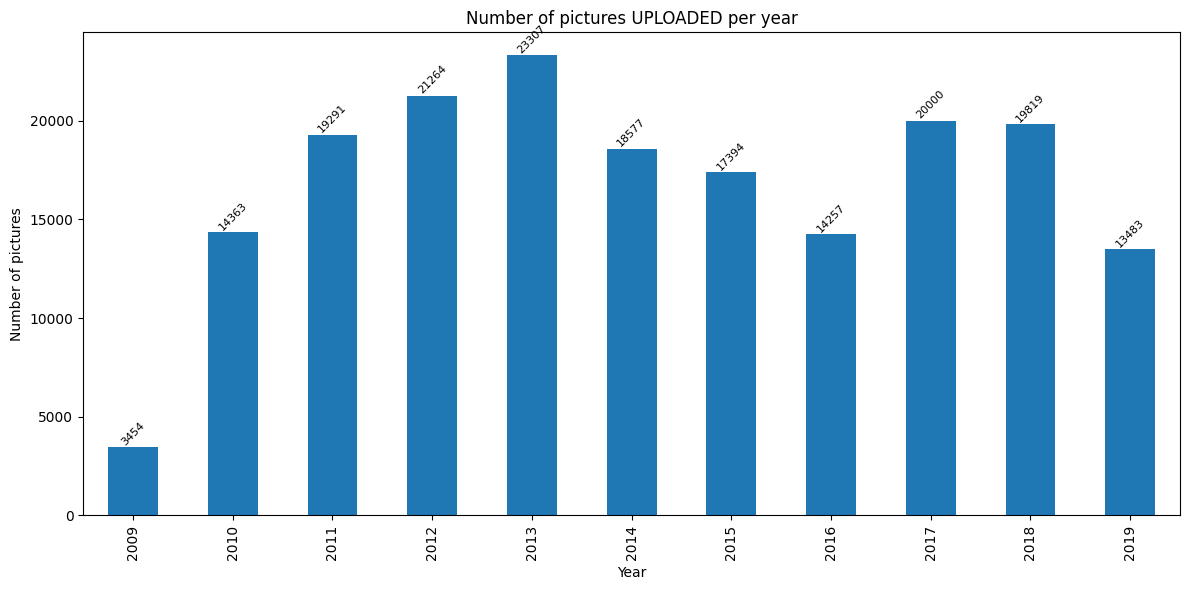

In [5]:
ax = df["date_upload"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures UPLOADED per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

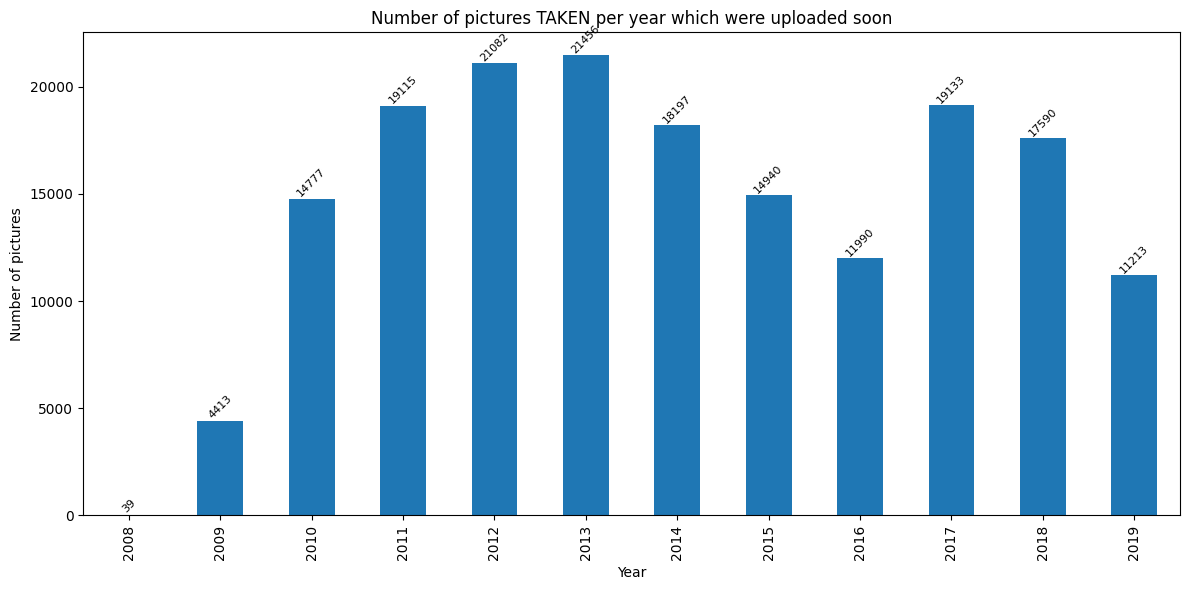

In [6]:
# distribution of pictures with the small difference between date_taken and date_upload
similar_mask = df["date_upload"].dt.year - df["date_taken"].dt.year <= 1
similar_year = df[similar_mask]
ax = similar_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

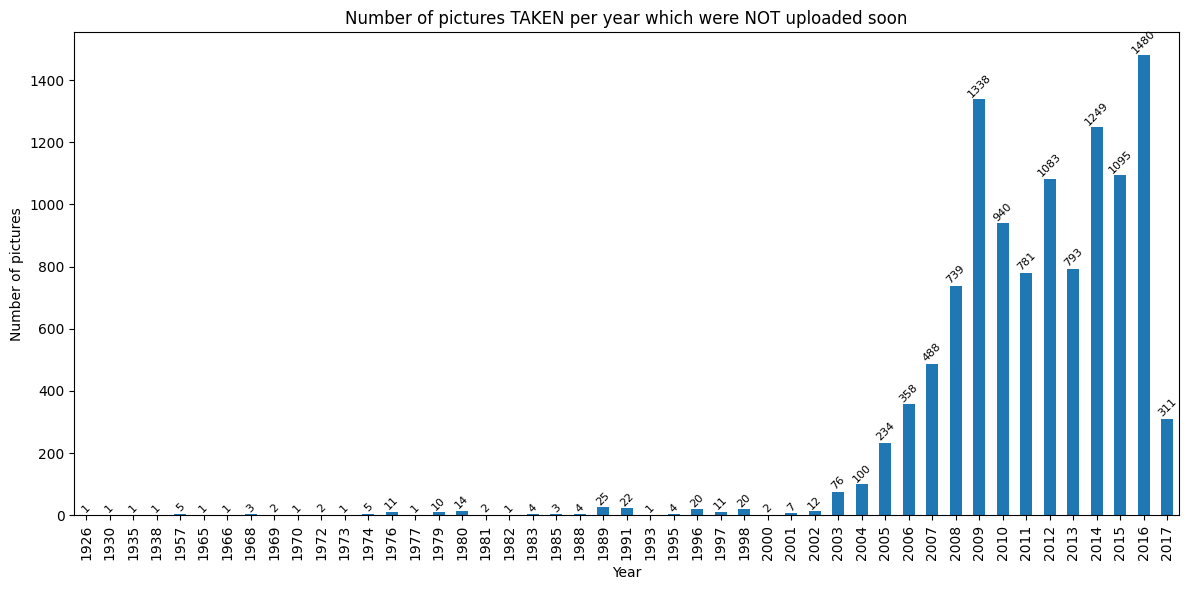

In [7]:
diff_year = df[~similar_mask]
ax = diff_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were NOT uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

In [8]:
df['similar_year'] = similar_mask

Total unique tags: 44568
Total tags: 2073924



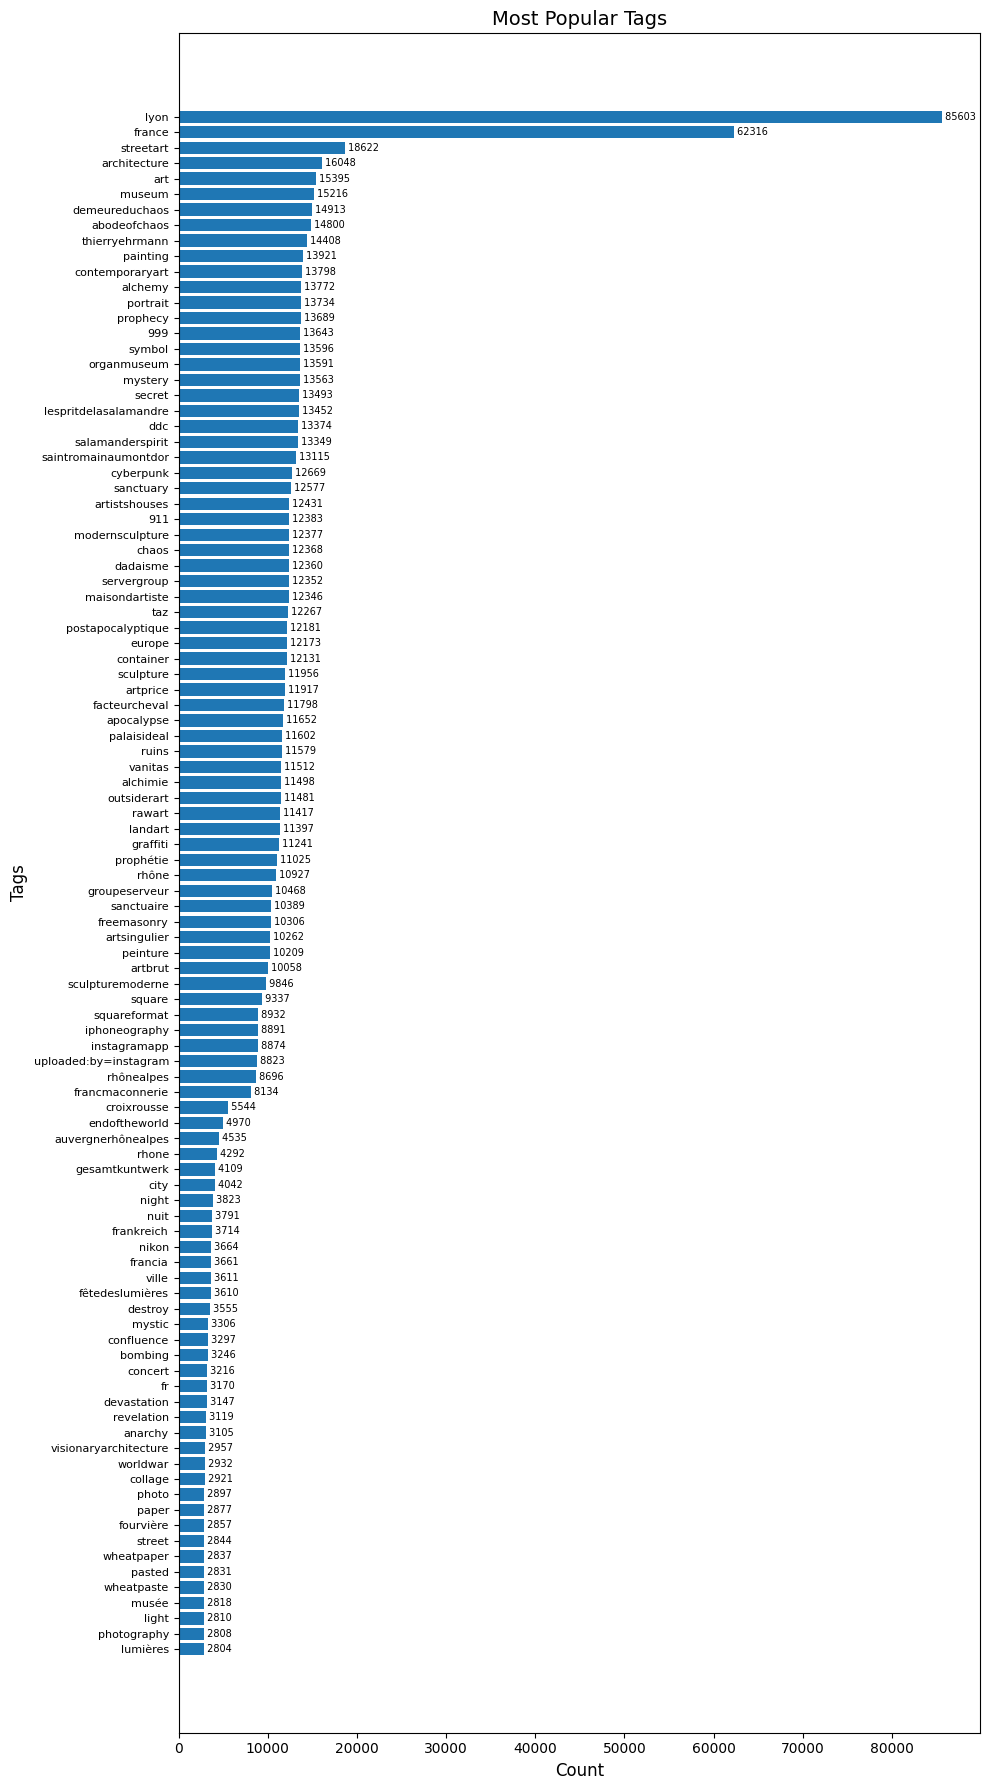

In [9]:
all_tags = []
for tags_list in df["tags"]:
    if tags_list and isinstance(tags_list, list):
        all_tags.extend(tags_list)

tag_counts = Counter(all_tags)
print(f"Total unique tags: {len(tag_counts)}")
print(f"Total tags: {len(all_tags)}\n")

top_tags = tag_counts.most_common(100)
tags, counts = zip(*top_tags)

fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(tags)), counts)
ax.set_yticks(range(len(tags)))
ax.set_yticklabels(tags, fontsize=8)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Most Popular Tags", fontsize=14)
ax.invert_yaxis()  # Most popular at the top

for i, count in enumerate(counts):
    ax.text(count, i, f" {count}", va='center', fontsize=7)

plt.tight_layout()
plt.show()

Total unique tags after filtering: 44510
Total tags after filtering: 1747073



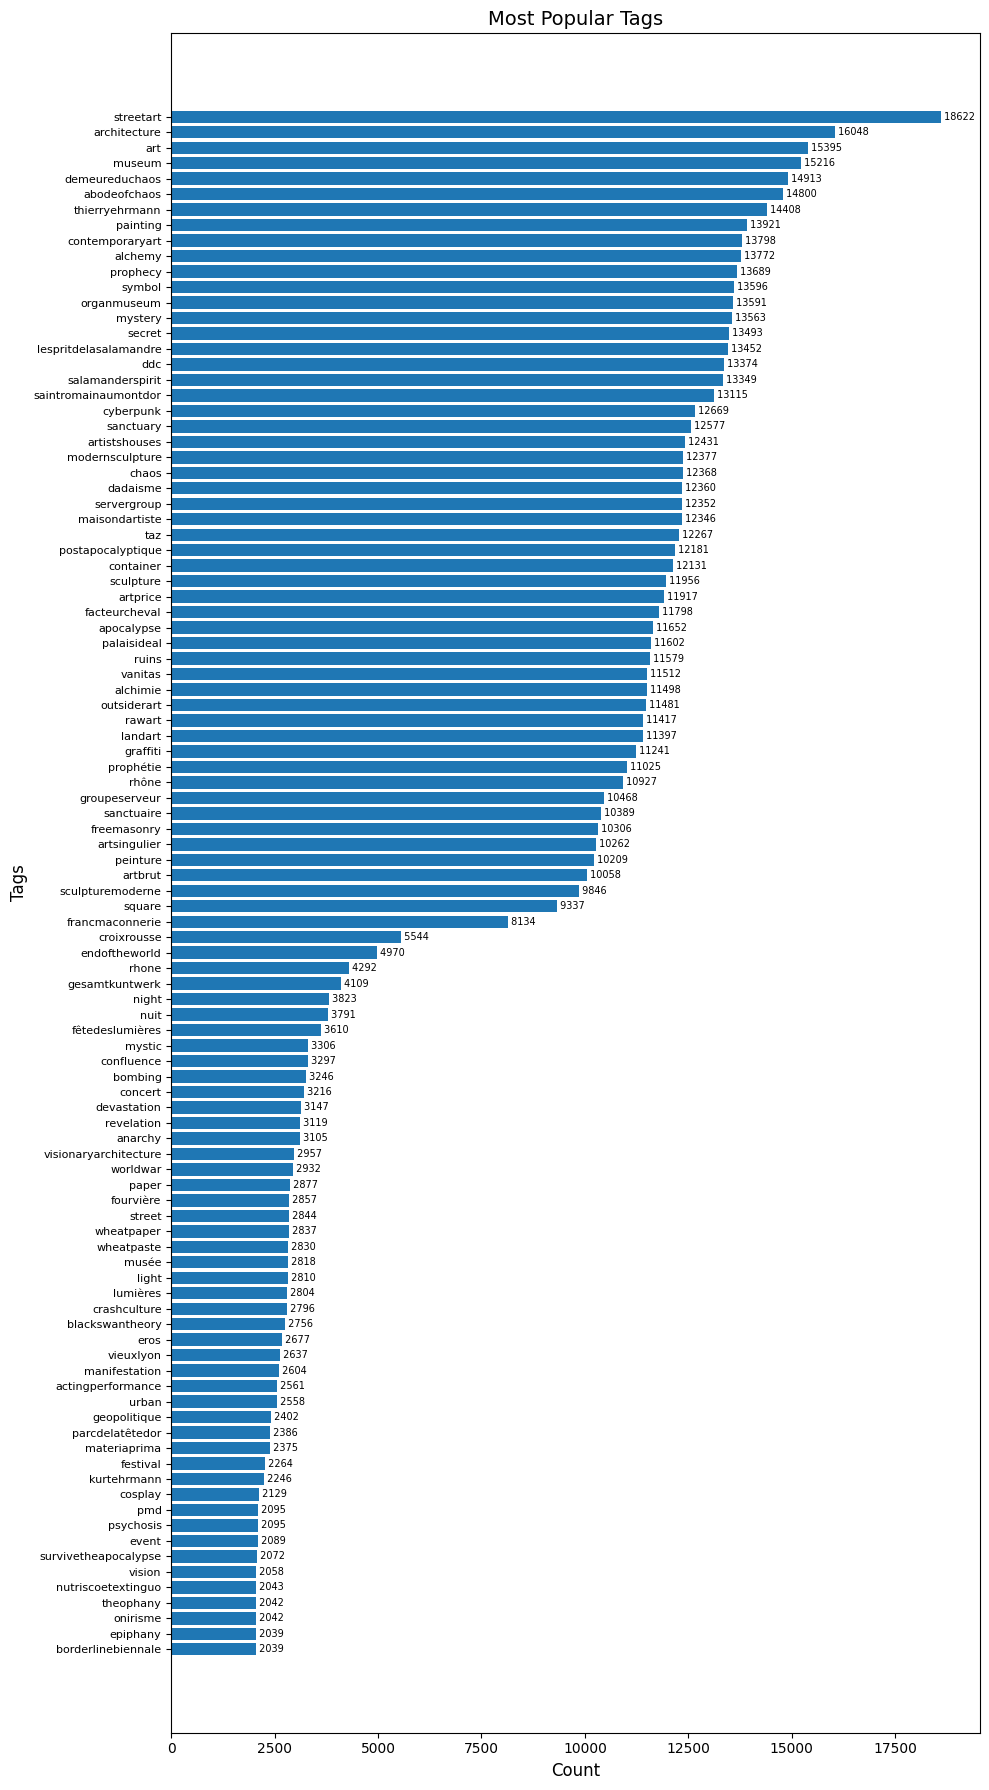

In [10]:
tags_to_delete = set(
    [
        "lyon",
        "france",
        "flickr",
        "photography",
        "photo",
        "travel",
        "city",
        "trip",
        "vacation",
        "tourism",
        "europe",
        "clouds",
        "people",
        "selfie",
        "portrait",
        "family",
        "friends",
        "fr",
        "destroy",
        "nikon",
        "canon",
        "uploaded",
        "uploaded:by=instagram",
        "ville",
        "francia",
        "collage",
        "999",
        "911",
        "frankreich",
        "auvergnerhônealpes",
        "rhônealpes",
        "instagramapp",
        "instagram",
        "lione",
        "69",
        "villeurbanne",
        "pasted",
        "live",
        "iphoneography",
        "2019",
        "2018",
        "2017",
        "2016",
        "2015",
        "2014",
        "2013",
        "2012",
        "2011",
        "2010",
        "2009",
        "2008",
        "2007",
        "2006",
        "2005",
        "2004",
        "frankrijk",
        "pasteup",
        "rhonealpes",
        "squareformat",
        "madeinfrance",
    ]
)

all_tags_filtered = [tag for tag in all_tags if tag not in tags_to_delete]
tag_counts_filtered = Counter(all_tags_filtered)
print(f"Total unique tags after filtering: {len(tag_counts_filtered)}")
print(f"Total tags after filtering: {len(all_tags_filtered)}\n")

top_tags_filtered = tag_counts_filtered.most_common(100)
tags, counts = zip(*top_tags_filtered)

fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(tags)), counts)
ax.set_yticks(range(len(tags)))
ax.set_yticklabels(tags, fontsize=8)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Most Popular Tags", fontsize=14)
ax.invert_yaxis()  # Most popular at the top

for i, count in enumerate(counts):
    ax.text(count, i, f" {count}", va="center", fontsize=7)

plt.tight_layout()
plt.show()

['.', ',', '!', '?', ';', ':', '/', '(', ')', '[', ']', '{', '}', '"', "'", '-', '+', '&', '*', '<', '>', '#', '@', '_', '^', '`', '$', '€', '£', '%', '§', '|', '±', '≥', '≤', '¿', '•', '°', '~', '≠', '=', '–', '—', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total unique words: 30745
Total words: 692799



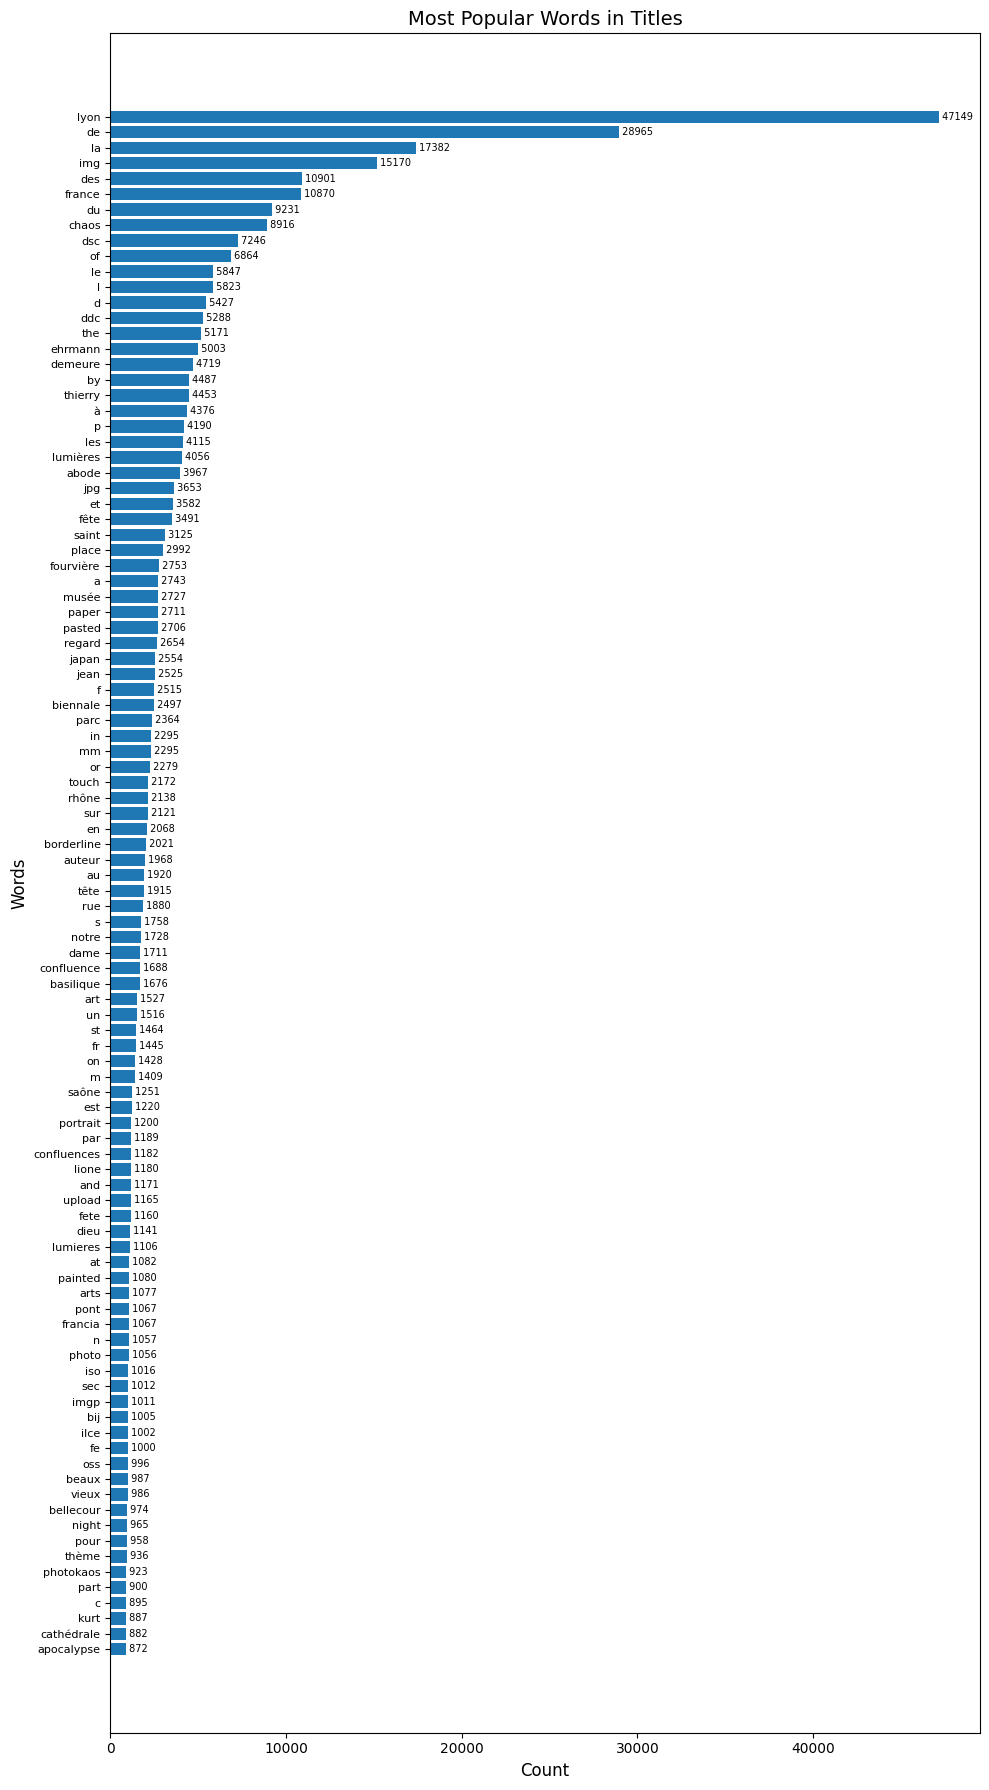

In [11]:
all_words = []

punc_signs = list(".,!?;:/()[]{}\"'-+&*<>#@_^`$€£%§|±≥≤¿•°~≠=–—")
punc_signs.extend([str(n) for n in range(0, 10)])
print(punc_signs)
for title in df["title"]:
    if title:
        # Remove punctuation and split by spaces
        cleaned = title
        for s in punc_signs:
            cleaned = cleaned.replace(s, " ")
        cleaned = cleaned.lower()
        words = cleaned.split()
        all_words.extend([word.lower() for word in words if word])

word_counts = Counter(all_words)
print(f"Total unique words: {len(word_counts)}")
print(f"Total words: {len(all_words)}\n")

top_words = word_counts.most_common(100)
words, counts = zip(*top_words)

fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(words)), counts)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words, fontsize=8)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Words", fontsize=12)
ax.set_title("Most Popular Words in Titles", fontsize=14)
ax.invert_yaxis()

for i, count in enumerate(counts):
    ax.text(count, i, f" {count}", va="center", fontsize=7)

plt.tight_layout()
plt.show()

{'2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '69',
 '911',
 '999',
 'a',
 'and',
 'at',
 'au',
 'auvergnerhônealpes',
 'aux',
 'b',
 'by',
 'c',
 'canon',
 'city',
 'clouds',
 'collage',
 'd',
 'de',
 'des',
 'destroy',
 'du',
 'e',
 'elle',
 'elles',
 'en',
 'est',
 'et',
 'europe',
 'f',
 'family',
 'fe',
 'flickr',
 'for',
 'fr',
 'france',
 'francia',
 'frankreich',
 'frankrijk',
 'friends',
 'from',
 'g',
 'h',
 'i',
 'il',
 'ils',
 'image',
 'img',
 'in',
 'instagram',
 'instagramapp',
 'iphoneography',
 'is',
 'j',
 'je',
 'jpg',
 'k',
 'l',
 'la',
 'le',
 'les',
 'lione',
 'live',
 'lyon',
 'm',
 'madeinfrance',
 'mm',
 'n',
 'nikon',
 'nous',
 'o',
 'of',
 'on',
 'or',
 'ou',
 'où',
 'p',
 'par',
 'pasted',
 'pasteup',
 'people',
 'photo',
 'photography',
 'portrait',
 'pour',
 'q',
 'r',
 'rhonealpes',
 'rhônealpes',
 's',
 'selfie',
 'squareformat',
 'st',
 'sur',
 't',
 'the'

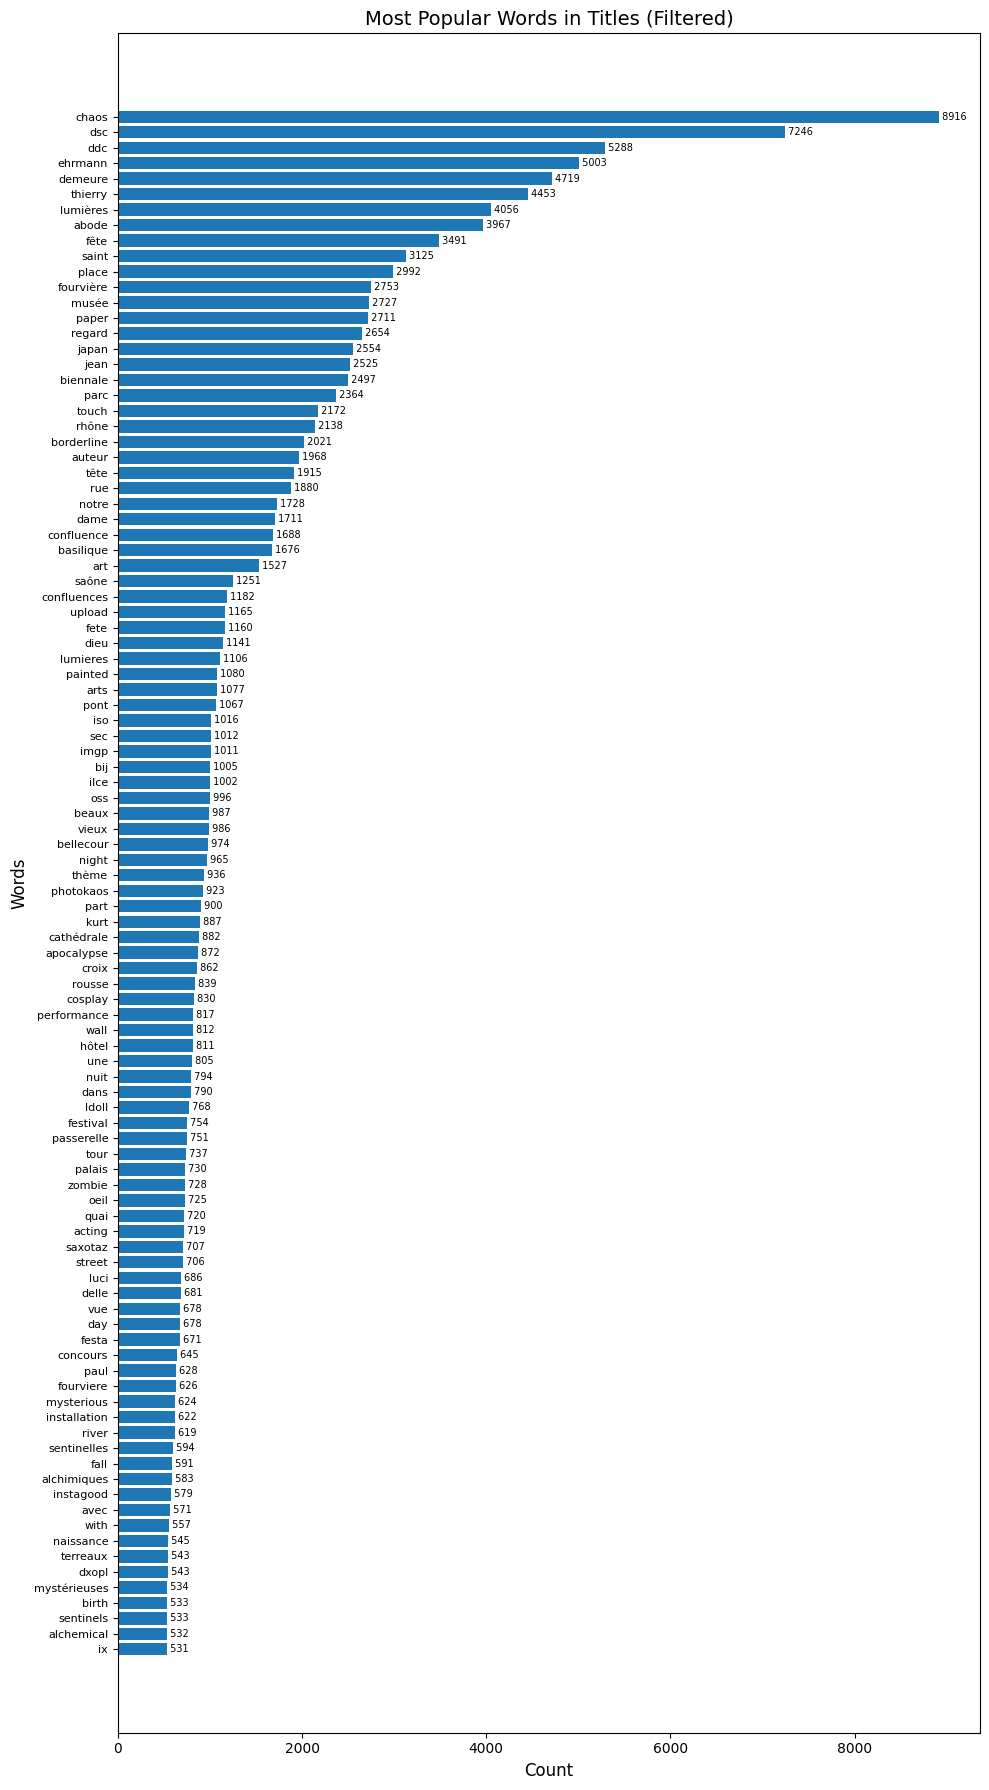

In [12]:
words_to_delete = [
    "de",
    "des",
    "la",
    "le",
    "je",
    "tu",
    "on",
    "nous",
    "vous",
    "ils",
    "i",
    "il",
    "elle",
    "elles",
    "you",
    "we",
    "they",
    "them",
    "fr",
    "en",
    "a",
    "au",
    "aux",
    "à",
    "the",
    "of",
    "by",
    "to",
    "par",
    "un",
    "in",
    "sur",
    "et",
    "and",
    "du",
    "d",
    "s",
    "les",
    "at",
    "l",
    "est",
    "is",
    "pour",
    "for",
    "or",
    "ou",
    "où",
    "mm",
    "m",
    "from",
    "b",
    "c",
    "e",
    "f",
    "g",
    "h",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",
    "img",
    "image",
    "jpg",
    "st",
    "fe",
]
words_to_delete.extend(list(tags_to_delete))
words_to_delete = set(words_to_delete)
pprint(words_to_delete)


all_words_filtered = [word for word in all_words if word not in words_to_delete]
word_counts_filtered = Counter(all_words_filtered)
print(f"Total unique words after filtering: {len(word_counts_filtered)}")
print(f"Total words after filtering: {len(all_words_filtered)}\n")

top_words_filtered = word_counts_filtered.most_common(100)
words, counts = zip(*top_words_filtered)

fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(words)), counts)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words, fontsize=8)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Words", fontsize=12)
ax.set_title("Most Popular Words in Titles (Filtered)", fontsize=14)
ax.invert_yaxis()

for i, count in enumerate(counts):
    ax.text(count, i, f" {count}", va="center", fontsize=7)

plt.tight_layout()
plt.show()

In [13]:
# save redundant tags to txt
with open("data/tags_to_delete.txt", "w") as f:
    f.write("\n".join(sorted(tags_to_delete)))
print("Tags to delete saved to data/tags_to_delete.txt")

# save redundant words to txt
with open("data/words_to_delete.txt", "w") as f:
    f.write("\n".join(sorted(words_to_delete)))
print("Words to delete saved to data/words_to_delete.txt")

# save puntuation signs to txt
with open("data/punc_signs.txt", "w") as f:
    f.write("".join(sorted(punc_signs)))
print("Punc. signs  saved to data/punc_signs.txt")


# Save df to pickle
df.to_pickle("data/flickr_data_with_features.pkl")
print("DataFrame saved to data/flickr_data_with_features.pkl")

Tags to delete saved to data/tags_to_delete.txt
Words to delete saved to data/words_to_delete.txt
Punc. signs  saved to data/punc_signs.txt
DataFrame saved to data/flickr_data_with_features.pkl
